# 4.2. Analyse des échantillons


## 4.2.1. Nombre d’échantillons

### Nombre de polygones par classe

#### Diagramme en bâtons

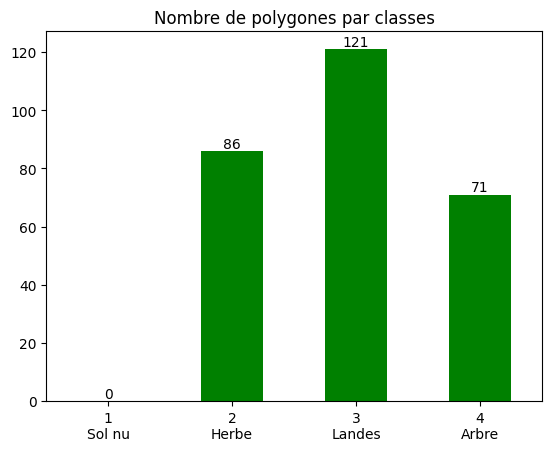

In [23]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os 

shp_path = os.path.join(
    "..",
    "data",
    "projet_eval",
    "PI_strates_bretagne_32630.shp"
)

echantillon_shp = gpd.read_file(shp_path)

# Dictionnaire de référence car la liste des classes est connue d'avance 
labels_strates = {
    1: "Sol nu",
    2: "Herbe",
    3: "Landes",
    4: "Arbre"
}

# Compter et forcer les strates attendues
counts = (
    echantillon_shp["strate"]
    .value_counts()
    .reindex(labels_strates.keys())
    .fillna(0)
)

fig, ax = plt.subplots()
counts.plot(kind="bar", ax=ax, color="green")

# Affiche les valeurs
for i, val in enumerate(counts):
    ax.text(i, val, int(val), ha="center", va="bottom") 

# Labels de l'axe X depuis le dictionnaire
ax.set_xticklabels([f"{s}\n{labels_strates[s]}" for s in counts.index], rotation=0)

# Titres graphique et axes
ax.set_title("Nombre de polygones par classes")
plt.xlabel('')
plt.ylabel('')

# Sortie
results_dir = os.path.join("..","results", "figure")

os.makedirs(results_dir,exist_ok=True) # Crée le dossier s'il n'existe pas

results_path = os.path.join(results_dir, "diag_baton_nb_poly_by_class.png")

plt.savefig(results_path)

plt.show()

#### Commentaire

On remarque que la distribution des échantillons est **déséquilibrée** : les landes sont la classe majoritaire tandis que **la classe « sol nu » est totalement absente**.

Cela pourra poser des problèmes plus tard, notamment lors de la classification supervisée, en créant des **biais**. En effet, sans échantillon de référence dans cette classe, l'apprentissage sera impossible pour cette classe. Les résultats seront donc à interpréter avec prudence, notamment pour la classe « sol nu ».

### Nombre de pixels par classe

#### Contrôles

Tout d'abord, on vérifie que tous nos fichiers de travail sont bien « **alignés** » : même résolution, même CRS, mêmes coordonnées à l'origine, mêmes dimensions. On utilise pour cela principalement des fonctions de ``libsigma``.

##### Résolution spatiale

In [2]:
import sys
sys.path.append(os.path.abspath(".."))

from libsigma.read_and_write import get_pixel_size, open_image

data_dir = os.path.join("..","data", "projet_eval")

# liste des rasters
files = sorted(
    f for f in os.listdir(data_dir)
    if f.startswith("bretagne_24-25")
)

pixel_sizes = [
    get_pixel_size(
        open_image(os.path.join(data_dir, f))
    )
    for f in files
]

if len(set(pixel_sizes)) == 1: # car un set supprime les doublons
    print("✅ Toutes les images ont la même résolution. Taille des pixels :", pixel_sizes[0])
else:
    print("❌ Les images n'ont PAS toutes la même résolution !")
    for f, ps in zip(files, pixel_sizes):
        print(f, ":", ps)

✅ Toutes les images ont la même résolution. Taille des pixels : (10.0, -10.0)


/opt/python/lib/python3.13/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


##### Système de projection

In [3]:
crs_list = [
    open_image(os.path.join(data_dir, f)).GetProjection()
    for f in files
]

if len(set(crs_list)) == 1: # car un set supprime les doublons
    print("✅ Toutes les images ont le même CRS :", crs_list[0])
else:
    print("❌ Les images n'ont PAS toutes le même CRS")
    for f, crs in zip(files, crs_list):
        print(f, ":", crs)

✅ Toutes les images ont le même CRS : PROJCS["WGS 84 / UTM zone 30N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32630"]]


In [4]:
gdf = gpd.read_file(shp_path)

print("CRS du shapefile :", gdf.crs)

CRS du shapefile : EPSG:32630


Toutes les images ainsi que le shapefile sont projetés en WGS 84.

##### Coordonnées du pixel à l'origine

In [5]:
from libsigma.read_and_write import get_origin_coordinates

origins = [
    get_origin_coordinates(
        open_image(os.path.join(data_dir, f))
    )
    for f in files
]

if len(set(origins)) == 1: # car un set supprime les doublons
    print("✅ Toutes les images ont la même origine :", origins[0])
else:
    print("❌ Les images n'ont PAS la même origine")
    for f, origin in zip(files, origins):
        print(f, ":", origin)


✅ Toutes les images ont la même origine : (432950.0, 5368890.0)


##### Dimensions

In [6]:
from libsigma.read_and_write import get_image_dimension

dimensions = [
    get_image_dimension(
        open_image(os.path.join(data_dir, f))
    )   # on ne garde que (nb_lignes, nb_colonnes)
    for f in files
]

if len(set(dimensions)) == 1: # car un set supprime les doublons
    print("✅ Toutes les images ont la même dimension :", dimensions[0])
else:
    print("❌ Les images n'ont PAS toutes la même dimension")
    for f, dim in zip(files, dimensions):
        print(f, ":", dim)

✅ Toutes les images ont la même dimension : (612, 1533, 6)


La fonction `get_image_dimension()` renvoie un triplet *(lignes, colonnes, bandes)*.

Les dimensions spatiales (lignes et colonnes) sont identiques pour toutes les images, ce qui confirme leur bon alignement.

En revanche, la présence de **6 bandes** par fichier est suspecte étant donné que **les images Sentinel-2 comportent 13 bandes** (dont on en sélectionne parfois 10).

On comprend donc que ces 6 bandes correspondent aux **6 dates d’acquisition**, et non à des bandes spectrales. Les différentes bandes spectrales sont donc réparties entre plusieurs fichiers (ce qui est cohérent avec leur nom « ``BXX`` »), chacun empilant les informations temporelles.

En l'état, le jeu de données fourni n'est **pas exploitable** car l’organisation des images est différente : **chaque fichier correspond à une bande spectrale** donnée, dans laquelle est « empilée » la **dimension temporelle**.

Afin de pouvoir travailler sur ces fichiers, il est donc nécessaire de **réorganiser ces données**.

#### Réorganisation des données

On fait l'**hypothèse** que l'ordre des bandes suit l'ordre chronologique des dates fournies dans l'énoncé, donc :

- 2025-03-31 → Bande 1
- 2025-04-10 → Bande 2
- 2025-05-15 → Bande 3
- 2025-06-17 → Bande 4
- 2025-07-12 → Bande 5
- 2025-08-10 → Bande 6

In [7]:
import numpy as np
from libsigma.read_and_write import load_img_as_array, write_image

dates = [
    "2025-03-31",
    "2025-04-10",
    "2025-05-15",
    "2025-06-17",
    "2025-07-12",
    "2025-08-10"
]

bands = ["B02","B03","B04","B05","B06","B07","B08","B8A","B11","B12"]

# Charge les 10 fichiers
arrays_by_band = [
    load_img_as_array(os.path.join(data_dir, f"bretagne_24-25_{b}.tif"))
    for b in bands
]

img_ds = open_image(os.path.join(data_dir, f"bretagne_24-25_{bands[0]}.tif"))

for t, date in enumerate(dates):
    img_t = np.stack([arr[:, :, t] for arr in arrays_by_band], axis=2)

    output_dir = os.path.join("..",data_dir, "data_ready")
    os.makedirs(output_dir,exist_ok=True) # Crée le dossier s'il n'existe pas
    output_path = os.path.join(output_dir, f"bretagne_24-25_{date}.tif")


    write_image(
        out_filename=output_path,
        array=img_t,
        data_set=img_ds
    )

Ce code crée un nouveau dossier ``data/projet_eval/data_ready`` qui contient les images retravaillées : 10 bandes pour chacune des 6 dates.

On vérifie que la manipulation s'est bien déroulée :

In [8]:
for date in dates:
    fname = f"bretagne_24-25_{date}.tif"
    fpath = os.path.join(output_dir, fname)

    dims = get_image_dimension(open_image(fpath))
    print(f"{fname} → {dims}")

bretagne_24-25_2025-03-31.tif → (612, 1533, 10)
bretagne_24-25_2025-04-10.tif → (612, 1533, 10)
bretagne_24-25_2025-05-15.tif → (612, 1533, 10)
bretagne_24-25_2025-06-17.tif → (612, 1533, 10)
bretagne_24-25_2025-07-12.tif → (612, 1533, 10)
bretagne_24-25_2025-08-10.tif → (612, 1533, 10)


#### Diagramme en bâtons

Pour **compter les pixels**, on peut choisir une image au hasard puisqu'on a vérifié qu'elles étaient toutes « alignées ».

Pour **rasteriser** le shapefile, OTB n'est pas disponible dans cet environnement, on utilise donc **GDAL**.

In [36]:
# Image de référence choisie arbitrairement
image_ref = os.path.join("..", "data", "projet_eval", "data_ready", "bretagne_24-25_2025-03-31.tif")

out_image = os.path.join("..", "temp", "echantillon_rasterize.tif")
os.makedirs(os.path.dirname(out_image), exist_ok=True)

# 1) Créer un raster vide calé sur ref_image
ref_ds = gdal.Open(ref_image)
cols, rows = ref_ds.RasterXSize, ref_ds.RasterYSize
gt, proj = ref_ds.GetGeoTransform(), ref_ds.GetProjection()

drv = gdal.GetDriverByName("GTiff")
roi_ds = drv.Create(out_image, cols, rows, 1, gdal.GDT_Int16)
roi_ds.SetGeoTransform(gt)
roi_ds.SetProjection(proj)
roi_ds.GetRasterBand(1).Fill(0)

roi_ds = None
ref_ds = None


roi_ds = gdal.Open(out_image, gdal.GA_Update)
gdal.Rasterize(roi_ds, shp_path, attribute="strate")
roi_ds = None

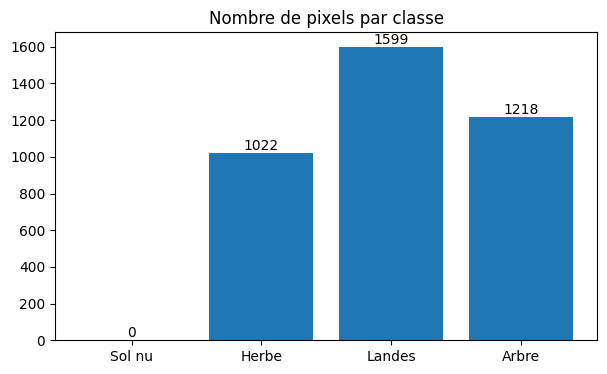

In [37]:
roi_ds = gdal.Open(out_image)
roi = roi_ds.GetRasterBand(1).ReadAsArray()
roi_ds = None

# On ignore les pixels à 0 (NoData)
values, counts = np.unique(roi[roi > 0], return_counts=True)

# Forcer l'ordre des classes attendues (1..4) + inclure les classes absentes
ordered_classes = list(labels_strates.keys())
counts_dict = dict(zip(values.tolist(), counts.tolist()))
ordered_counts = [counts_dict.get(c, 0) for c in ordered_classes]
ordered_labels = [labels_strates[c] for c in ordered_classes]

plt.figure(figsize=(7, 4))
plt.bar(ordered_labels, ordered_counts)

for i, v in enumerate(ordered_counts):
    plt.text(i, v, str(int(v)), ha="center", va="bottom")


plt.title("Nombre de pixels par classe")
plt.ylabel("")
plt.xlabel("")

result_path = os.path.join(results_dir, "diag_baton_nb_pix_by_class.png")
plt.savefig(result_path, dpi=300, bbox_inches="tight")

plt.show()

#### Commentaire

Le comptage en pixels met en évidence que **la classe « Arbre » occupe la surface la plus importante**, bien que le nombre de polygones n'était pas majoritaire.

En cohérence avec le diagramme précédent, on a **0 pixel** pour dans la classe « sol nu »

## 4.2.2. Phénologie des strates, mise en évidence des landes

# 4.3. Production d'une carte de strates à l'échelle du pixel

## 4.3.1. Choix du classifieur et sa paramétrisation

## 4.3.2. Stratégie de validation

## 4.3.3. Contribution des variables

## 4.3.4. Production des cartes finales

## 4.3.5. Analyse des résultats